In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree as KDTree
from tqdm import tqdm

## Load Data

In [2]:
def buildGraph(barcodes_df, d_th):
    G = nx.Graph()
    n =0
    for exp in barcodes_df.experiment.unique():
        cells = barcodes_df.loc[barcodes_df.experiment==exp, 'cellID'].unique()
        for cell in cells:
            barcodes_df_tmp = barcodes_df.loc[(barcodes_df.experiment==exp) & (barcodes_df.cellID==cell),:].copy()
            barcodes_df_tmp.reset_index(drop=True, inplace=True)
            
            if not barcodes_df_tmp.empty:
                gene_list = barcodes_df.geneName.unique()

                kdT = KDTree(np.array([barcodes_df_tmp.RNACentroidX.values,barcodes_df_tmp.RNACentroidY.values]).T)
                res = kdT.query_pairs(d_th)
                res = [(x[0]+n,x[1]+n) for x in list(res)]

                # Add nodes
                G.add_nodes_from((barcodes_df_tmp.index.values+n), test=False, val=False, label=0)
                # Add edges
                G.add_edges_from(res)

                n = n + barcodes_df_tmp.shape[0]

    return G

In [3]:
def plotNeighbor(barcodes_df):
    d_list=[]
    for exp in barcodes_df.experiment.unique():
        cells = barcodes_df.loc[barcodes_df.experiment==exp, 'cellID'].unique()
        for cell in cells:
            barcodes_df_tmp = barcodes_df.loc[(barcodes_df.experiment==exp) & (barcodes_df.cellID==cell),:].copy()
            barcodes_df_tmp.reset_index(drop=True, inplace=True)
            if not barcodes_df_tmp.empty:
                # Find mean distance to nearest neighbor
                kdT = KDTree(np.array([barcodes_df_tmp.RNACentroidX.values,barcodes_df_tmp.RNACentroidY.values]).T)
                d,i = kdT.query(np.array([barcodes_df_tmp.RNACentroidX.values,barcodes_df_tmp.RNACentroidY.values]).T,k=2)
                d_list.append(d)
    d = np.vstack(d_list)
    print(d.shape)
    plt.hist(d[:,1],bins=200);
    plt.axvline(x=np.percentile(d[:,1],97),c='r')
    print(np.percentile(d[:,1],97))
    d_th = np.percentile(d[:,1],97)
    return d_th
#     plt.xlim([0,5])

In [4]:
import os

if not os.path.exists('../data/MERFISH_Chen_et_al_2015/barcodes.xlsx')
    ! wget http://zhuang.harvard.edu/MERFISHData/140genesData.xlsx -O ../data/MERFISH_Chen_et_al_2015/barcodes.xlsx
        
barcodes_df = pd.read_excel("../data/MERFISH_Chen_et_al_2015/barcodes.xlsx", sep=',', names=['experiment','library','cellID','intCodeword','geneName','isExactMatch','isCorrectedMatch','CellPositionX','CellPositionY','RNACentroidX','RNACentroidY'], header=0)
barcodes_df.shape

(747569, 11)

In [5]:
# Remove unsassigned barcodes in Moffit et al.
remove_genes = ['blank001', 'blank002', 'blank003', 'blank004', 'blank005',
       'notarget001', 'notarget002', 'notarget003', 'notarget004',
       'notarget005']
barcodes_df = barcodes_df[~barcodes_df.geneName.isin(remove_genes)]
barcodes_df.reset_index(drop=True, inplace=True)
barcodes_df.shape

(740043, 11)

In [6]:
barcodes_df.geneName.unique().shape

(130,)

(740043, 2)
6.48749065356921


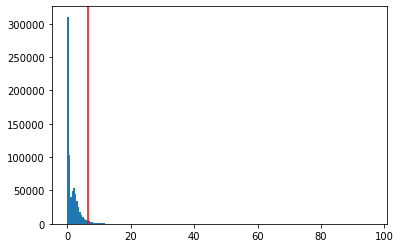

In [7]:
d_th = plotNeighbor(barcodes_df)

In [8]:
G = buildGraph(barcodes_df, d_th)

In [9]:
# Remove components with less than N nodes
node_removed = []
N=3
for component in tqdm(list(nx.connected_components(G))):
    if len(component)<N:
        for node in component:
#             node_removed.append(node)
            G.remove_node(node)

100%|██████████| 47702/47702 [00:00<00:00, 641944.25it/s]


In [10]:
print(G.number_of_nodes())

701437


In [11]:
barcodes_df.shape

(740043, 11)

In [12]:
def removeNotConnNodes(barcodes_df, d_th):
    G = nx.Graph()
    n =0
    node_removed = []
    index_removed = []
    for exp in barcodes_df.experiment.unique():
        for cell in barcodes_df.cellID.unique():
            barcodes_df_tmp = barcodes_df.loc[(barcodes_df.experiment==exp) & (barcodes_df.cellID==cell),:].copy()
    
            if not barcodes_df_tmp.empty:
                index_removed = index_removed + barcodes_df_tmp.index.values.tolist()
                barcodes_df_tmp.reset_index(drop=True, inplace=True)
                gene_list = barcodes_df.geneName.unique()

                kdT = KDTree(np.array([barcodes_df_tmp.RNACentroidX.values,barcodes_df_tmp.RNACentroidY.values]).T)
                res = kdT.query_pairs(d_th)
                res = [(x[0]+n,x[1]+n) for x in list(res)]

                # Add nodes
                G.add_nodes_from((barcodes_df_tmp.index.values+n), test=False, val=False, label=0)
                # Add edges
                G.add_edges_from(res)

                n = n + barcodes_df_tmp.shape[0]

    # Remove components with less than N nodes
    N=3
    for component in tqdm(list(nx.connected_components(G))):
        if len(component)<N:
            for node in component:
                node_removed.append(node)
                G.remove_node(node)      
                        
    index_removed = np.array(index_removed)
    return index_removed[node_removed]

In [13]:
remove = removeNotConnNodes(barcodes_df, d_th)

100%|██████████| 47702/47702 [00:00<00:00, 656410.97it/s]


## Load Embedding

In [14]:
X = np.load('../results/MERFISH_Chen_et_al/embedding_MERFISH_Chen_et_al.npy')

In [15]:
X.shape

(701437, 50)

In [16]:
barcodes_df.shape

(740043, 11)

In [17]:
# remove not connected spots
barcodes_df = barcodes_df[~barcodes_df.index.isin(remove)]
barcodes_df.reset_index(drop=True, inplace=True)
barcodes_df.shape

(701437, 11)

## UMAP - 2D Visualization

In [29]:
import umap

reducer = umap.UMAP(
    n_neighbors=10,
    n_components=2,
    n_epochs=500,
    init='spectral',
    min_dist=0.1,
    spread=1,
    random_state=42,
    verbose = True
)
embedding = reducer.fit_transform(X)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=500,
     n_neighbors=10, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Mon Jun  1 10:27:42 2020 Finding Nearest Neighbors
Mon Jun  1 10:27:42 2020 Building RP forest with 47 trees
Mon Jun  1 10:29:13 2020 NN descent for 19 iterations
	 0  /  19
	 1  /  19
Mon Jun  1 10:30:01 2020 Finished Nearest Neighbor Search
Mon Jun  1 10:30:22 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	comp

In [30]:
np.save('../results/MERFISH_Chen_et_al/MERFISH_Chen_et_al_umap.npy',embedding)

In [18]:
embedding = np.load('../results/MERFISH_Chen_et_al/MERFISH_Chen_et_al_umap.npy')

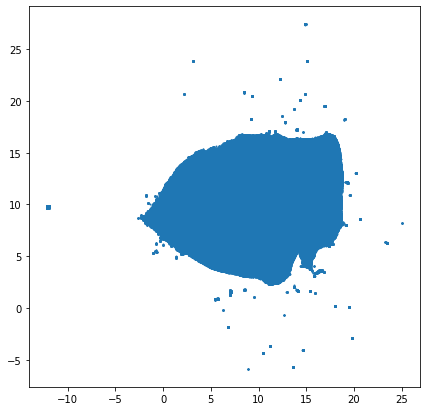

In [20]:
%matplotlib inline
plt.figure(figsize=(7,7))
plt.scatter(embedding[:,0], embedding[:,1], s=1)

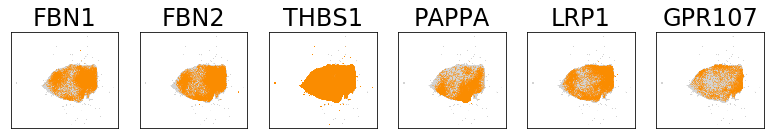

In [19]:
%matplotlib inline
# Group I genes from Chen et al.
import matplotlib.pyplot as plt

group1 = ['FBN1', 'FBN2', 'THBS1', 'PAPPA', 'LRP1', 'GPR107']

fig=plt.figure(figsize=(13.5,7.5))
for i, gene in enumerate(group1):
    plt.subplot(1,6,i+1)
    plt.scatter(embedding[barcodes_df.geneName!=gene,0], embedding[barcodes_df.geneName!=gene,1],s=1, alpha=0.1, c='lightgray', marker='.', linewidths=0, edgecolors=None)
    plt.scatter(embedding[barcodes_df.geneName==gene,0], embedding[barcodes_df.geneName==gene,1],s=1, c='darkorange', marker='.', linewidths=0, edgecolors=None)
    plt.title(gene, fontsize=20);
    plt.axis('scaled');
    plt.xticks([])
    plt.yticks([])

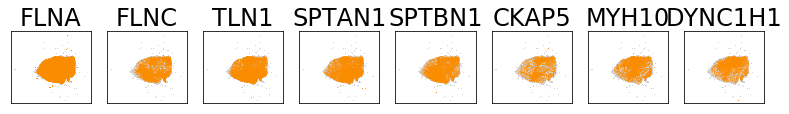

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

# Group II genes from Chen et al.
group2 = ['FLNA', 'FLNC', 'TLN1', 'SPTAN1', 'SPTBN1', 'CKAP5', 'MYH10', 'DYNC1H1']

fig=plt.figure(figsize=(13.5,7.5))
for i, gene in enumerate(group2):
    plt.subplot(1,8,i+1)
    plt.scatter(embedding[barcodes_df.geneName!=gene,0], embedding[barcodes_df.geneName!=gene,1],s=1, alpha=0.1, c='lightgray', marker='.', linewidths=0, edgecolors=None)
    plt.scatter(embedding[barcodes_df.geneName==gene,0], embedding[barcodes_df.geneName==gene,1],s=1, c='darkorange', marker='.', linewidths=0, edgecolors=None)
    plt.title(gene, fontsize=20);
    plt.axis('scaled');
    plt.xticks([])
    plt.yticks([])

## Clustering with Scanpy

In [21]:
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../results/MERFISH_Chen_et_al/MERFISH_Chen_et_al.h5'  # the file that will store the analysis results

scanpy==1.5.1 anndata==0.7.3 umap==0.4.2 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1


In [23]:
adata = sc.AnnData(X=X)

In [19]:
# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=15)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:03:28)


In [ ]:
sc.tl.leiden(adata, random_state = 42)

running Leiden clustering


In [ ]:
adata.obs['Gene'] = barcodes_df.geneName.values

In [ ]:
# save clustering data
adata.write(results_file)

In [22]:
# Load clustering data
adata = sc.read(results_file)

/home/gabpa510/miniconda3/envs/spage2vec_publication/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/gabpa510/miniconda3/envs/spage2vec_publication/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [23]:
# Extract leiden clusters
col_cluster = adata.obs['leiden'].values.astype(int)
col = np.unique(col_cluster)

In [24]:
# Add leiden clusters to spots dataframe
barcodes_df = barcodes_df.copy()
barcodes_df.loc[:,'cluster'] = adata.obs['leiden'].values
go_clusters = np.unique(adata.obs['leiden'].values)
barcodes_df.head()

,experiment,library,cellID,intCodeword,geneName,isExactMatch,isCorrectedMatch,CellPositionX,CellPositionY,RNACentroidX,RNACentroidY,cluster
0,1,1,0,33796,SCUBE3,0,1,475.5,630.6,78.723714,154.452489,28
1,1,1,0,34048,SCUBE3,0,1,475.5,630.6,81.297819,229.918727,28
2,1,1,0,33794,SON,0,1,475.5,630.6,92.627268,212.018163,28
3,1,1,0,32802,AFF4,0,1,475.5,630.6,101.404081,220.580093,32
4,1,1,0,33856,FOSB,0,1,475.5,630.6,107.676392,173.956553,1


## Compare with Chen et al.

In [25]:
def heat_map(df, labels, sort=None, cluster_colors=None, 
             cluster_number = False, save=False, name='', fontsz=8):
    """
    Plot heat_map of a dataframe.
    Input:
    `df`(pandas dataframe): Dataframe to plot. Cells as columns, genes as rows.
    `labels`(list/array): list of labels of the cells in the same order as the 
        df columns.
    `sort`(list): List of sorted cluster numbers. If None it will plot them in
        assending order
    `cluster_colors`(dict): Dictionary matching cluster numbers with colors
        in the hex fomat. Like '#ff0000' for red
    `cluster_number`(bool): Show cluster numbers in the top color bar. Usefull
        when manually sorting the clusters.
    `save`(bool): option to save the figure as png with 300dpi.
    `name`(str): Name to use when saving
    
    """
    #Find the name of the input df, for logging
    df_input_name =[x for x in globals() if globals()[x] is df][0]
    print('df used for plot: {}'.format(df_input_name))
    
    if sort == None:
        optimal_order = np.unique(labels)    
    else:
        optimal_order = sort
    print('Order of clusters: {}'.format(optimal_order))
    
    cl, lc = gen_labels(df, np.array(labels))[:2]
    
    #Sort the cells according to the optimal cluster order
    optimal_sort_cells = sum([lc[i] for i in optimal_order], [])
    
    #Create a list of optimal sorted cell labels
    optimal_sort_labels = [cl[i] for i in optimal_sort_cells]
    
    fig, axHM = plt.subplots(figsize=(20,20))
    
    df_full = df.copy()
    z = df_full.values
#     z = z/np.percentile(z, 99, 1)[:,None]
    z = pd.DataFrame(z, index=df_full.index, columns=df_full.columns)
    z = z.loc[:,optimal_sort_cells]
#     z = z.sort_values(list(z.columns),axis=0, ascending=False)
    
    
    im = axHM.pcolormesh(z.values, cmap='viridis')
    
    plt.yticks(np.arange(0.5, len(df.index), 1), z.index, fontsize=fontsz)
    plt.gca().invert_yaxis()
    plt.xlim(xmax=len(labels))
    plt.xticks(np.arange(0.5,df.shape[1],step=1), labels=z.columns, rotation='vertical', fontsize=fontsz)

    divider = make_axes_locatable(axHM)
    axLabel = divider.append_axes("top", .3, pad=0, sharex=axHM)
    
    counter = Counter(labels)
    pos=0
    if cluster_colors == None:
        optimal_sort_labels = np.array(optimal_sort_labels)
        axLabel.pcolor(optimal_sort_labels[None,:]/max(optimal_sort_labels), cmap='nipy_spectral')
        if cluster_number==True:
            for l in optimal_order:
                axLabel.text(pos + (counter[l]/2), 1.2, l, fontsize=fontsz,
                         horizontalalignment='center', verticalalignment='center')
                pos += Counter(labels)[l]
        
    else:
        for l in optimal_order:
            #Use Bottom instead of y for older versions of matplotlib
            axLabel.barh(y = 0, left = pos, width = counter[l], color=cluster_colors[l],
                        linewidth=0.5, edgecolor=cluster_colors[l])
            if cluster_number==True:
                axLabel.text(pos + (counter[l]/2), 0, l, fontsize=fontsz,
                         horizontalalignment='center', verticalalignment='center')
            pos += Counter(labels)[l]
    
    axLabel.set_xlim(xmax=len(labels))
    axLabel.axis('off')
    
    cax = fig.add_axes([.91, 0.13, 0.01, 0.22])
    colorbar = fig.colorbar(im, cax=cax, ticks=[0,1])
    colorbar.set_ticklabels(['0', 'max'])
    
    if save == True:
        plt.savefig('{}.png'.format(name), dpi=300)
    

In [26]:
def post_merge(df, labels, post_merge_cutoff, linkage_method='single', 
               linkage_metric='correlation', fcluster_criterion='distance'):
    """
    Merge clusters based on likage and a cutoff. The mean expression levels of 
    the clusters are linked and them merged based on the cutoff provided.
    Input:
    `df`(Pandas dataframe): df with expression matrix. row-genes, col-cells.
    `labels`(list/array): Labels of the cells.
    `post_merge_cutoff`(float): Merge clusters that have a distance from each 
        other below the cutoff.
    `linkage_method`(string): Scipy linkage methods. Default = 'single'
    `linkage_metric`(string): Scipy lingae metric. Default = 'correlation'
    `fcluster_criterion`(string): Scipy fcluster criterion. Default = 'distance'

    Returns:
    `new_labels`(list): List of new cell labels after merging. 
    Additionally it plots the dendrogram showing which clusters are merged.

    """
    Z = scipy.cluster.hierarchy.linkage(df.T, method=linkage_method, metric=linkage_metric)
    merged_labels_short = scipy.cluster.hierarchy.fcluster(Z, post_merge_cutoff, criterion=fcluster_criterion)

    #Update labels  
    label_conversion = dict(zip(df.columns, merged_labels_short))
    label_conversion_r = dict(zip(merged_labels_short, df.columns))
    new_labels = [label_conversion[i] for i in labels] 

    #Plot the dendrogram to visualize the merging
    fig, ax = plt.subplots(figsize=(20,10))
    scipy.cluster.hierarchy.dendrogram(Z, labels=df.columns ,color_threshold=post_merge_cutoff)
    ax.hlines(post_merge_cutoff, 0, ax.get_xlim()[1])
    ax.set_title('Merged clusters')
    ax.set_ylabel(linkage_metric, fontsize=20)
    ax.set_xlabel('pre-merge cluster labels', fontsize=20)
    ax.tick_params(labelsize=10)

#     verboseprint('Merged clusters. Started with {} clusters, merging results to {} clusters.'.format(
#         len(np.unique(labels)), len(np.unique(merged_labels_short))))

#     for k in label_conversion.keys():
#         verboseprint('Old label:{:>3} is converted to: {}'.format(k, label_conversion[k]))

    return new_labels

def gen_labels(df, model):
    """
    Generate cell labels from model.
    Input:
    `df`: Panda's dataframe that has been used for the clustering. (used to 
    get the names of colums and rows)
    `model`(obj OR array): Clustering object. OR numpy array with cell labels.
    Returns (in this order):
    `cell_labels` = Dictionary coupling cellID with cluster label
    `label_cells` = Dictionary coupling cluster labels with cellID
    `cellID` = List of cellID in same order as labels
    `labels` = List of cluster labels in same order as cells
    `labels_a` = Same as "labels" but in numpy array
    
    """
    if str(type(model)).startswith("<class 'sklearn.cluster"):
        cell_labels = dict(zip(df.columns, model.labels_))
        label_cells = {}
        for l in np.unique(model.labels_):
            label_cells[l] = []
        for i, label in enumerate(model.labels_):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model.labels_)
        labels_a = model.labels_
    elif type(model) == np.ndarray:
        cell_labels = dict(zip(df.columns, model))
        label_cells = {}
        for l in np.unique(model):
            label_cells[l] = []
        for i, label in enumerate(model):
            label_cells[label].append(df.columns[i])
        cellID = list(df.columns)
        labels = list(model)
        labels_a = model
    else:
        print('Error wrong input type')
    
    return cell_labels, label_cells, cellID, labels, labels_a

#### Create cluster gene expression matrix

In [27]:
hm = barcodes_df.groupby(['geneName','cluster']).size().unstack(fill_value=0)
hm.shape

(130, 59)

#### Normalize expression matrix

In [28]:
# Z-score (cluster-wise) normalization
from sklearn.preprocessing import scale

hm = pd.DataFrame(scale(hm.values,axis=0), columns=hm.columns, index=hm.index)
hm.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
geneName,,,,,,,,,,,,,,,,,,,,,
ABCA2,-0.101748,-0.218928,-0.232902,-0.142784,-0.323750,-0.272307,-0.260115,-0.199572,-0.210776,-0.158072,...,-0.089735,-0.089874,-0.088045,-0.095674,-0.088045,-0.088045,-0.088045,-0.088045,-0.088045,-0.093106
AFAP1,-0.096572,-0.155387,-0.221113,-0.139027,-0.122131,-0.164894,-0.200405,-0.225193,-0.182203,-0.140119,...,-0.089735,-0.089874,-0.088045,-0.095674,-0.088045,-0.088045,-0.088045,-0.088045,-0.088045,-0.093106
AFF4,-0.094847,-0.224405,-0.205788,-0.148043,-0.279182,-0.272307,-0.146667,-0.246010,-0.058390,-0.090483,...,-0.089735,-0.089874,-0.088045,-0.095674,-0.088045,-0.088045,-0.088045,-0.088045,-0.088045,-0.093106
AGPS,-0.106492,-0.247411,-0.254121,-0.157058,-0.387419,-0.314902,-0.273549,-0.270030,-0.233906,-0.178138,...,-0.089735,-0.089874,-0.088045,-0.095674,-0.088045,-0.088045,-0.088045,-0.088045,-0.088045,-0.093106
AKAP11,-0.107354,-0.247411,-0.249405,-0.162317,-0.389542,-0.331569,-0.272057,-0.290847,-0.232545,-0.186587,...,-0.089735,-0.089874,-0.088045,-0.095674,-0.088045,-0.088045,-0.088045,-0.088045,-0.088045,-0.093106


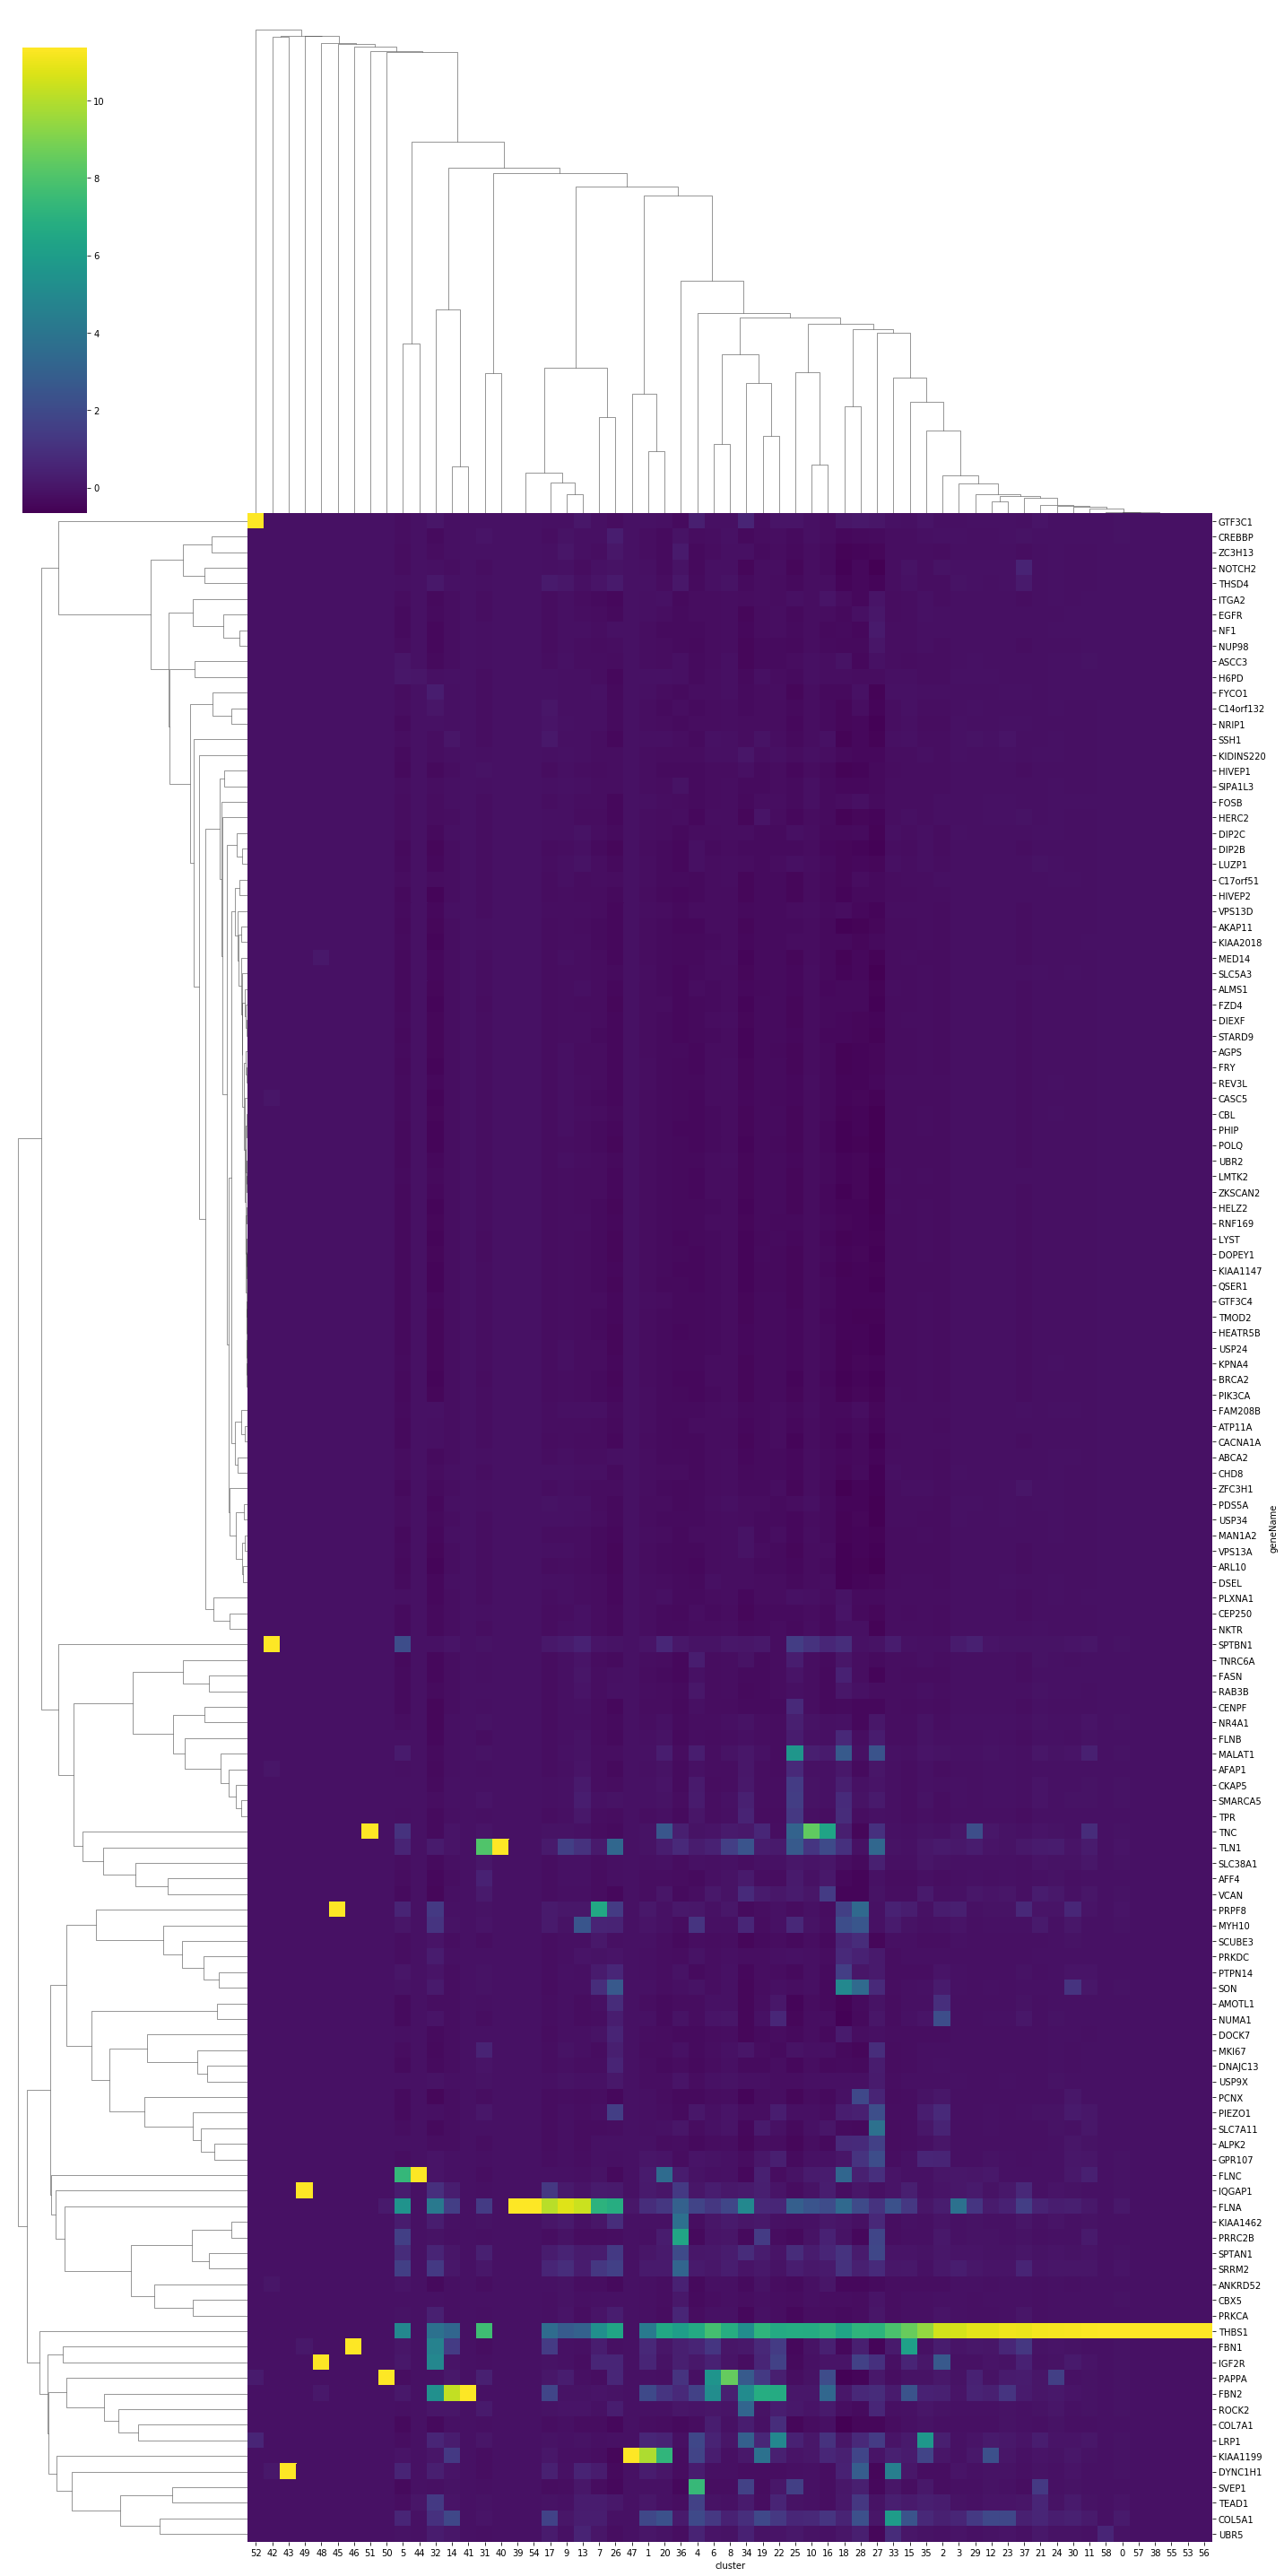

In [29]:
# Plot hierarchical clustering based on correlation
import seaborn as sns
g = sns.clustermap(hm, row_cluster=True, metric='correlation', method='average', cmap='viridis', figsize=(20,40))
# g.savefig('/mnt/hdd1/users/gabpa510/heatmap.svg', dpi=500, bbox_inches='tight', pad_inches=0.0)

#### Merge high correlated clusters

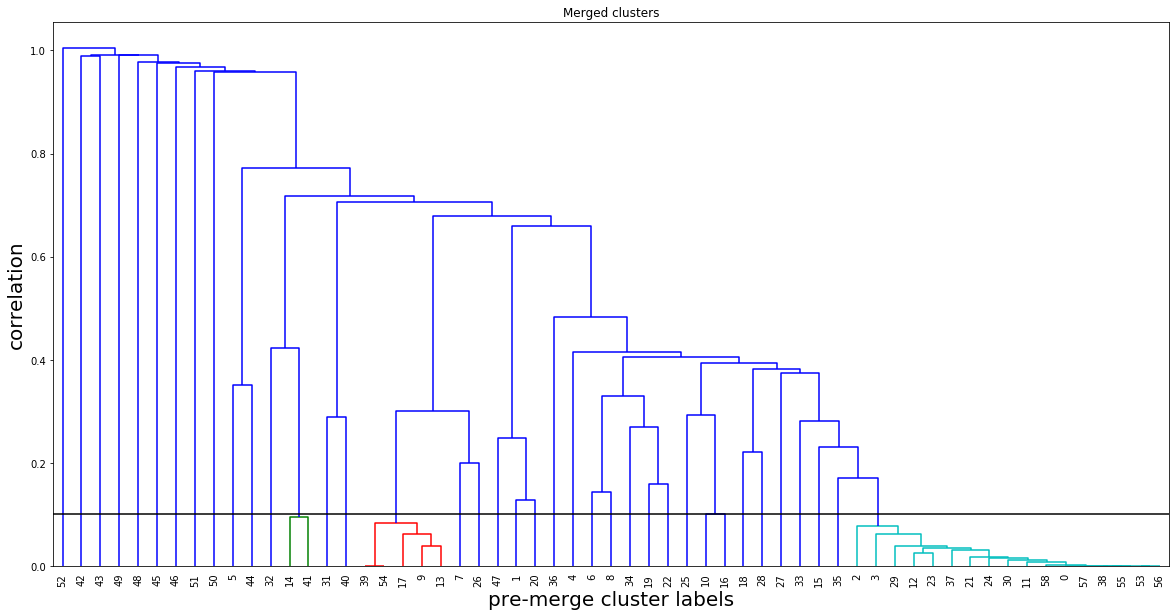

In [30]:
import scipy
hm_merge = post_merge(hm, hm.columns, 0.1, linkage_metric='correlation', linkage_method='average')

In [31]:
# Macroclusters
np.unique(hm_merge)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38], dtype=int32)

In [32]:
# Create cluster gene expression matrix
hm = barcodes_df.groupby(['geneName','cluster']).size().unstack(fill_value=0)
hm.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
geneName,,,,,,,,,,,,,,,,,,,,,
ABCA2,14,39,33,28,48,47,19,60,29,32,...,0,0,0,0,0,0,0,0,0,0
AFAP1,26,97,43,33,143,105,59,44,50,49,...,0,0,0,0,0,0,0,0,0,0
AFF4,30,34,56,21,69,47,95,31,141,96,...,0,0,0,0,0,0,0,0,0,0
AGPS,3,13,15,9,18,24,10,16,12,13,...,0,0,0,0,0,0,0,0,0,0
AKAP11,1,13,19,2,17,15,11,3,13,5,...,0,0,0,0,0,0,0,0,0,0


In [33]:
hm_macro = pd.DataFrame(np.zeros((hm.shape[0], np.unique(hm_merge).shape[0])), index=hm.index, columns=np.unique(hm_merge))

for d in np.unique(hm_merge):
    # merge clusters by summing the expression
    hm_macro.loc[:,d] = hm.iloc[:,np.where(np.array(hm_merge)==d)[0]].sum(axis=1)

In [34]:
hm_macro.shape

(130, 38)

In [35]:
# Annotate macro clusters
hm_merge = np.array(hm_merge)
for macro_go in np.unique(hm_merge):
    barcodes_df.loc[barcodes_df.cluster.astype(int).isin(np.where(np.isin(hm_merge,[macro_go]))[0]),'macro_cluster'] = macro_go

#### Filter out smaller clusters

In [36]:
hm_macro.sum(0)

1        109
2         96
3      25225
4         95
5      19159
6      11191
7      11464
8        134
9      63621
10     24002
11     14355
12     31049
13     17545
14        70
15     25123
16     23909
17     17824
18     16243
19     10499
20     23566
21     18878
22     14490
23     18198
24     12784
25    217728
26      6962
27     18969
28     11013
29     13970
30     26071
31      6705
32        49
33        45
34        72
35        74
36        60
37        53
38        37
dtype: int64

In [37]:
cluster_min_size = 1000

hm_macro = hm_macro.loc[:,hm_macro.sum(0)[hm_macro.sum(0) > cluster_min_size].index.values]
embedding = embedding[barcodes_df.macro_cluster.isin(hm_macro.sum(0)[hm_macro.sum(0) > cluster_min_size].index.values)]
barcodes_df = barcodes_df[barcodes_df.macro_cluster.isin(hm_macro.sum(0)[hm_macro.sum(0) > cluster_min_size].index.values)]

In [38]:
hm_macro.shape

(130, 26)

In [39]:
# Z-score (cluster-wise) normalization
from sklearn.preprocessing import scale

hm_macro = pd.DataFrame(scale(hm_macro.values,axis=0), columns=hm_macro.columns, index=hm_macro.index)
hm_macro.head()

,3,5,6,7,9,10,11,12,13,15,...,22,23,24,25,26,27,28,29,30,31
geneName,,,,,,,,,,,,,,,,,,,,,
ABCA2,-0.272307,-0.207472,-0.286091,-0.156969,-0.187496,-0.199572,-0.142490,-0.218928,-0.281605,-0.260115,...,-0.399732,-0.379315,-0.361319,-0.143348,-0.214997,-0.218012,-0.227151,-0.473162,-0.323750,-0.298820
AFAP1,-0.164894,-0.148801,-0.351538,-0.138404,-0.120834,-0.225193,-0.334336,-0.155387,-0.086392,-0.200405,...,0.740321,0.144145,-0.294960,-0.126656,-0.095441,-0.206174,-0.145311,0.010480,-0.122131,-0.321471
AFF4,-0.272307,-0.192032,-0.405086,0.471601,-0.128345,-0.246010,-0.142490,-0.224405,-0.214886,-0.146667,...,0.170294,-0.374512,-0.488509,-0.126942,-0.153005,-0.233232,-0.230074,-0.132569,-0.279182,-0.245967
AGPS,-0.314902,-0.221367,-0.428885,-0.223274,-0.216133,-0.270030,-0.406810,-0.247411,-0.298902,-0.273549,...,-0.457177,-0.537793,-0.494039,-0.154031,-0.214997,-0.238306,-0.247612,-0.445915,-0.387419,-0.283719
AKAP11,-0.331569,-0.221367,-0.458634,-0.170230,-0.219888,-0.290847,-0.406810,-0.247411,-0.306315,-0.272057,...,-0.284843,-0.557003,-0.510629,-0.155939,-0.184001,-0.239997,-0.244689,-0.432291,-0.389542,-0.374323


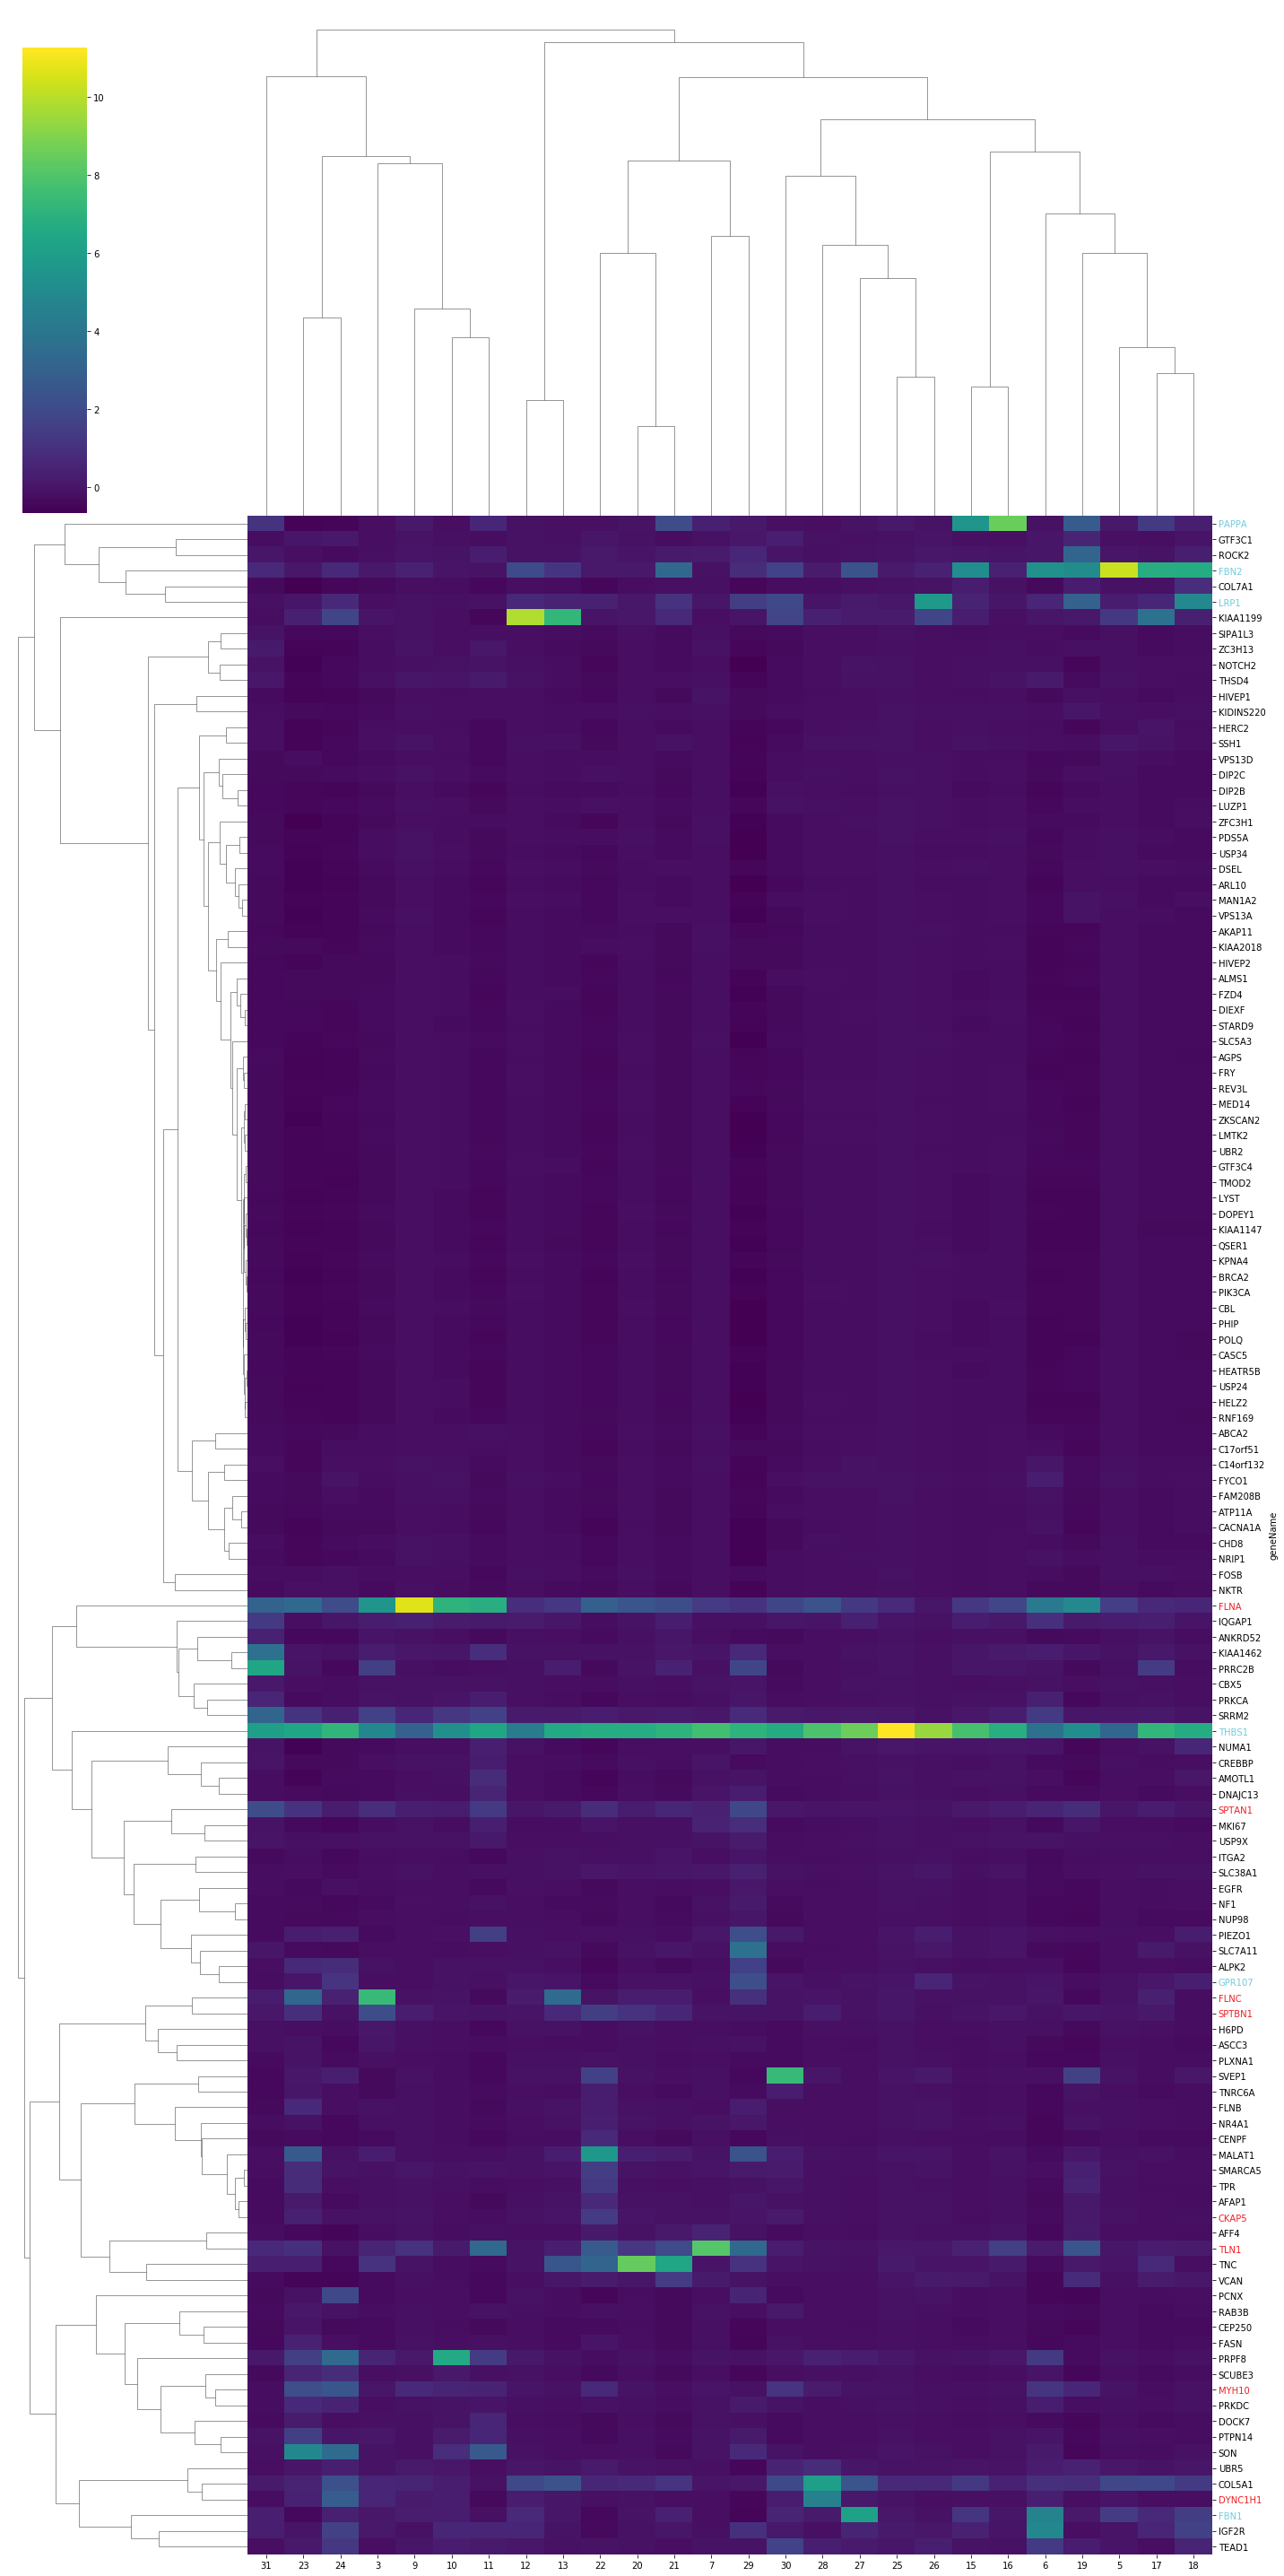

In [40]:
# Plot hierarchical clustering based on correlation
import seaborn as sns
g = sns.clustermap(hm_macro, row_cluster=True, metric='correlation', method='average', cmap='viridis', figsize=(20,40))

for tick_label in g.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    if tick_text in group1:
        tick_label.set_color('#6FCCDD')
    elif tick_text in group2:
        tick_label.set_color('#ED1F24')

[1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1]

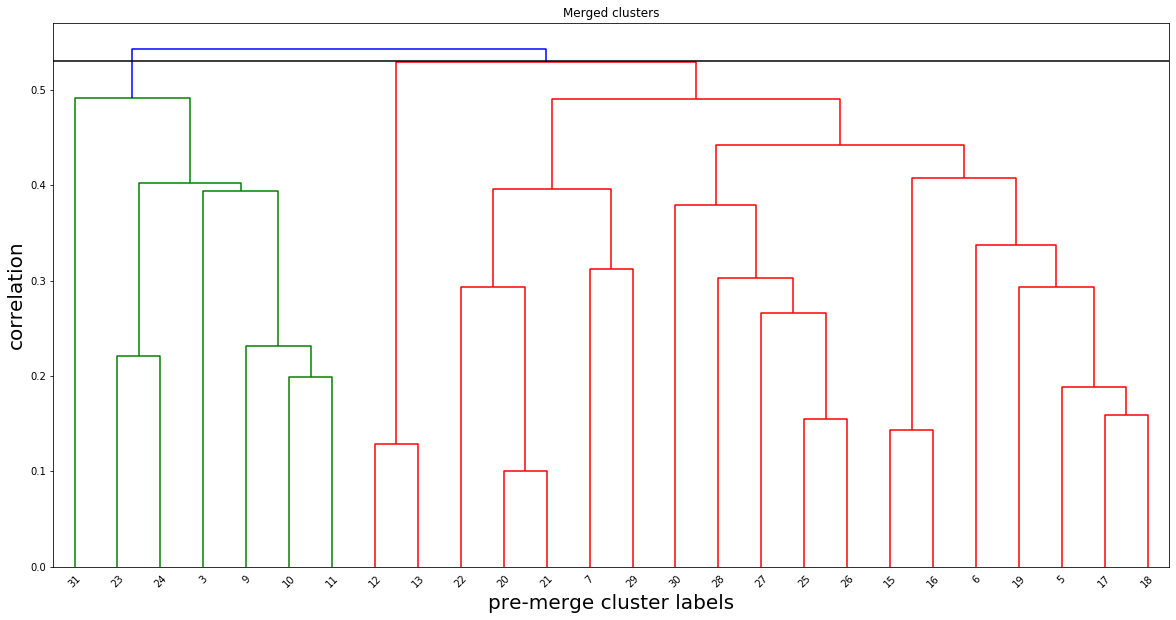

In [48]:
post_merge(hm_macro, hm_macro.columns, 0.53, linkage_metric='correlation', linkage_method='average')

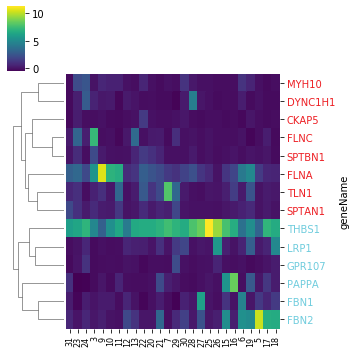

In [49]:
col_ordered_Fig5b_sup1 = [31,23,24,3,9,10,11,12,13,22,20,21,7,29,30,28,27,25,26,15,16,6,19,5,17,18] 
g = sns.clustermap(hm_macro.loc[group1+group2,col_ordered_Fig5b_sup1], col_cluster=False, row_cluster=True, metric='correlation', method='average', cmap='viridis', figsize=(5,5), xticklabels=True)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 8)

for tick_label in g.ax_heatmap.axes.get_yticklabels():
    tick_text = tick_label.get_text()
    if tick_text in group1:
        tick_label.set_color('#6FCCDD')
    elif tick_text in group2:
        tick_label.set_color('#ED1F24')

In [50]:
import matplotlib.pyplot as plt

low_exp_clusters = barcodes_df.macro_cluster.value_counts()[barcodes_df.macro_cluster.value_counts() < cluster_min_size].index.values
high_exp_clusters = barcodes_df.macro_cluster.value_counts()[barcodes_df.macro_cluster.value_counts() > cluster_min_size].index.values

#### Extract highly expressed genes from clusters for GO analysis

In [51]:
z_score_th = 1

print('{')
for cluster in high_exp_clusters:
    print(str(int(cluster))+ ' : ' + str(hm_macro.loc[hm_macro.loc[:,cluster] > z_score_th, cluster].index.tolist()) + ',')
print('}')

{
25 : ['ABCA2', 'AGPS', 'AKAP11', 'ALMS1', 'ARL10', 'ATP11A', 'BRCA2', 'C17orf51', 'CACNA1A', 'CASC5', 'CBL', 'CEP250', 'CHD8', 'DIEXF', 'DIP2B', 'DIP2C', 'DOPEY1', 'DSEL', 'EGFR', 'FAM208B', 'FOSB', 'FRY', 'FZD4', 'GTF3C4', 'HEATR5B', 'HELZ2', 'HERC2', 'HIVEP1', 'HIVEP2', 'KIAA1147', 'KIAA2018', 'KPNA4', 'LMTK2', 'LUZP1', 'LYST', 'MAN1A2', 'MED14', 'NKTR', 'NRIP1', 'NUP98', 'PDS5A', 'PHIP', 'PIK3CA', 'PLXNA1', 'POLQ', 'QSER1', 'REV3L', 'RNF169', 'SIPA1L3', 'SLC5A3', 'STARD9', 'THBS1', 'TMOD2', 'UBR2', 'USP24', 'USP34', 'VPS13A', 'VPS13D', 'ZFC3H1', 'ZKSCAN2'],
9 : ['AGPS', 'ALMS1', 'C14orf132', 'CASC5', 'CBL', 'CHD8', 'DIEXF', 'DIP2C', 'FLNA', 'HELZ2', 'KIAA1147', 'KPNA4', 'LUZP1', 'MED14', 'NKTR', 'NRIP1', 'PDS5A', 'QSER1', 'REV3L', 'RNF169', 'SIPA1L3', 'SSH1', 'STARD9', 'THSD4', 'TMOD2', 'UBR2', 'USP24', 'USP34'],
12 : ['FOSB', 'GTF3C4', 'KIAA1199'],
30 : ['DIP2B', 'GTF3C1', 'LUZP1', 'MYH10', 'RAB3B', 'SVEP1', 'TEAD1', 'TNRC6A', 'UBR5'],
3 : ['ANKRD52', 'ASCC3', 'FLNA', 'FLNC', 'H6

# Plot spage2vec clusters

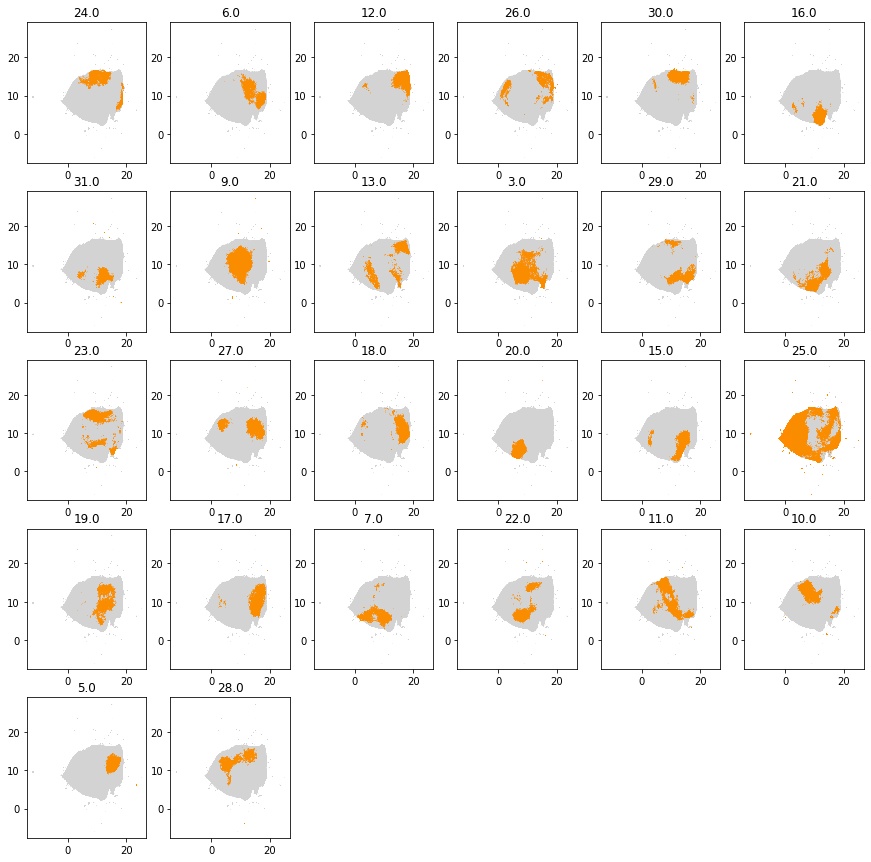

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i, cluster in enumerate(barcodes_df.macro_cluster.unique()):
    plt.subplot(5,6,i+1)
    plt.scatter(embedding[barcodes_df.macro_cluster!=cluster,0], embedding[barcodes_df.macro_cluster!=cluster,1],s=1, alpha=0.1, c='lightgray', marker='.', linewidths=0, edgecolors=None)
    plt.scatter(embedding[barcodes_df.macro_cluster==cluster,0], embedding[barcodes_df.macro_cluster==cluster,1],s=1, c='darkorange', marker='.', linewidths=0, edgecolors=None)
    plt.title(cluster);

In [22]:
# Assign sample ID to each cell
i = 0
for exp in barcodes_df.experiment.unique():
    cells = barcodes_df.loc[barcodes_df.experiment==exp, 'cellID'].unique()
    for cell in cells:
        barcodes_df.loc[(barcodes_df.experiment==exp) & (barcodes_df.cellID==cell), 'sampleID'] = i
        i = i+1

In [46]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def plot_cells(cluster=21):
    
    plt.figure(figsize=(25, 85*5))
    for cell in barcodes_df.sampleID.unique():
        plt.subplot(85,5, int(cell)+1)
        barcodes_tmp = barcodes_df.loc[barcodes_df.sampleID==cell,:]
        plt.scatter(barcodes_tmp[barcodes_tmp.macro_cluster!=cluster].RNACentroidX, barcodes_tmp[barcodes_tmp.macro_cluster!=cluster].RNACentroidY, s=35, alpha=0.7, c='lightgray', marker='.', linewidths=0, edgecolors=None)
        plt.scatter(barcodes_tmp[barcodes_tmp.macro_cluster==cluster].RNACentroidX, barcodes_tmp[barcodes_tmp.macro_cluster==cluster].RNACentroidY, s=35, c='tomato', marker='.', linewidths=0, edgecolors=None)
        plt.axis('equal');
        plt.title(cell)

interactive(children=(IntSlider(value=21, description='cluster', max=63, min=-21), Output()), _dom_classes=('w…